# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

In [1]:
import scipy
print(scipy.__version__)
# from scipy.misc import imread, imresize this library is deprecated with 1.3 and higher versions, hence using a replacement with matplotlib and skimage

1.4.1


Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from matplotlib.pyplot import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

Let's write starter functions in order to reduce the redundancy

#### Code to visualize the results of the training and validation accuracy

In [4]:
import matplotlib.pyplot as plt

def visualize_accuracy(history, epochs):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

Let's experiment with batch_size=100, so that we can first see the limit upto which we can occupy the resources

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#adding batch_size as 100
batch_size = 100

In [6]:
print('Train len  :' ,len(train_doc))
print('Val len  :' ,len(val_doc))

Train len  : 663
Val len  : 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
#Fucntion to resize the images

from PIL import Image
import numpy as np
from skimage.io import imread  # Assuming you're using skimage to read images
import os

# Function to resize and crop images
def resize_and_crop_image(input_image, crop_box, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    cropped_image = pil_image.crop(crop_box)
    resized_image = cropped_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)


In [10]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Normalize and add to batch
                    batch_data[folder, idx] = image / 255.0
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    batch_data[folder, idx] = image / 255.0

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model:1 CONV3D with batch size 100

In [97]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
# Set the number of classes and input shape

classes = 5
input_shape = (30, 120, 120, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling3D((1, 2, 2)))  # Pooling to reduce dimensionality

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu"))

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [98]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 30, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 30, 60, 60, 16)    3472      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 30, 30, 30, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 30, 30, 30, 32)    13856     
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 30, 15, 15, 32)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [99]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [100]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [101]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [102]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 100
Epoch 1/20


2024-10-26 18:47:34.949505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


7/7 [==============================] - ETA: 0s - loss: 2.5160 - categorical_accuracy: 0.2157 Source path =  /home/datasets/Project_data/val ; batch size = 100

Epoch 00001: val_loss improved from inf to 1.59433, saving model to model_init_2024-10-2618_47_14.858691/model-00001-2.51605-0.21569-1.59433-0.23000.h5
7/7 [==============================] - 135s 21s/step - loss: 2.5160 - categorical_accuracy: 0.2157 - val_loss: 1.5943 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.6025 - categorical_accuracy: 0.2066 
Epoch 00002: val_loss did not improve from 1.59433
7/7 [==============================] - 118s 19s/step - loss: 1.6025 - categorical_accuracy: 0.2066 - val_loss: 1.5968 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.5815 - categorical_accuracy: 0.2051 
Epoch 00003: val_loss improved from 1.59433 to 1.56315, saving model to model_init_2024-10-2618

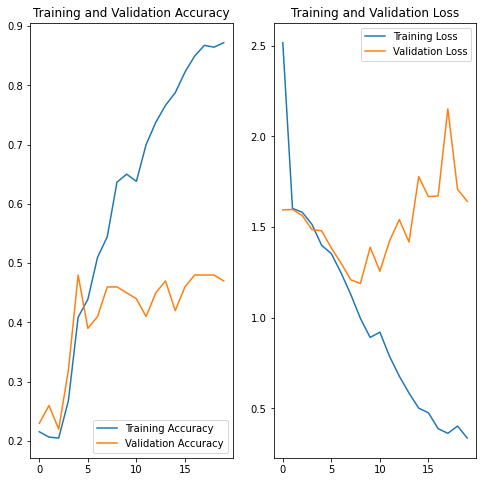

In [103]:
visualize_accuracy(history, num_epochs)

#### Observations: overfitting occurs

### Model:2 CONV3D with batch size 100 + dropout and batch normalizations

In [105]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

classes = 5
input_shape = (30, 120, 120, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))  # Pooling to reduce dimensionality

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.5))  # Further increased Dropout

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

In [106]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 30, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_5 (Batc  (None, 30, 60, 60, 16)   64        
 hNormalization)                                                 
                                                      

In [107]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [108]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [109]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [110]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 100
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 2.1850 - categorical_accuracy: 0.3605Source path =  /home/datasets/Project_data/val ; batch size = 100

Epoch 00001: val_loss improved from inf to 1.64047, saving model to model_init_2024-10-2619_26_19.704120/model-00001-2.18499-0.36048-1.64047-0.20000.h5
7/7 [==============================] - 74s 12s/step - loss: 2.1850 - categorical_accuracy: 0.3605 - val_loss: 1.6405 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.0869 - categorical_accuracy: 0.6440
Epoch 00002: val_loss improved from 1.64047 to 1.61332, saving model to model_init_2024-10-2619_26_19.704120/model-00002-1.08693-0.64404-1.61332-0.23000.h5
7/7 [==============================] - 69s 11s/step - loss: 1.0869 - categorical_accuracy: 0.6440 - val_loss: 1.6133 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
7/7 [====

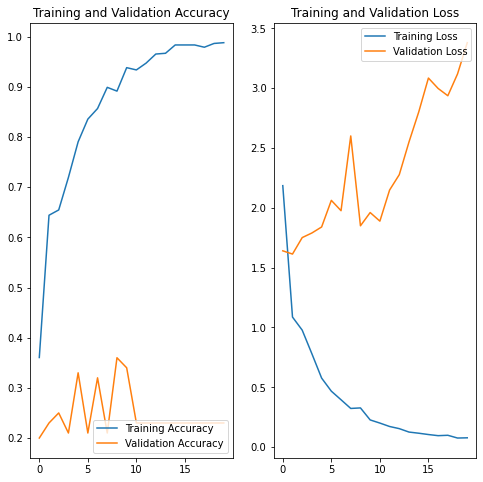

In [111]:
visualize_accuracy(history, num_epochs)

#### OBSERVATIONS: high overfitting

### Model:3 CONV3D with batch size 64 + dropout and batch normalizations

In [114]:
batch_size=64

In [115]:
classes = 5
input_shape = (30, 120, 120, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))  # Pooling to reduce dimensionality

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.5))  # Further increased Dropout

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

In [116]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 30, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 60, 60, 16)   64        
 chNormalization)                                                
                                                      

In [117]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [118]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [119]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [120]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.9570 - categorical_accuracy: 0.4027 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 2.30140, saving model to model_init_2024-10-2619_58_32.943283/model-00001-1.95696-0.40271-2.30140-0.25000.h5
11/11 [==============================] - 124s 12s/step - loss: 1.9570 - categorical_accuracy: 0.4027 - val_loss: 2.3014 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.2434 - categorical_accuracy: 0.5852 
Epoch 00002: val_loss improved from 2.30140 to 1.88008, saving model to model_init_2024-10-2619_58_32.943283/model-00002-1.24340-0.58522-1.88008-0.29000.h5
11/11 [==============================] - 117s 12s/step - loss: 1.2434 - categorical_accuracy: 0.5852 - val_loss: 1.8801 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/20

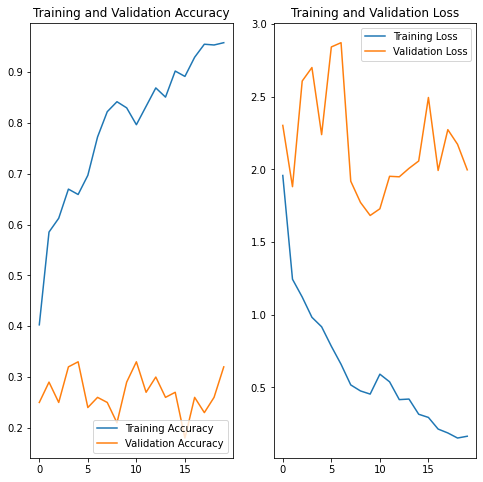

In [121]:
visualize_accuracy(history, num_epochs)

### OBSERVATIONS: We can see that there is higher overfitting

#### MODEL 4: CONV3D + BATCH SIZE 64+ DROPOUT+ SGD OPTIMIZER

In [24]:
batch_size=64

In [25]:
classes = 5
input_shape = (30, 120, 120, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))  # Pooling to reduce dimensionality

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.5))  # Further increased Dropout

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

In [26]:
#Adding the SGD optimizer
from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 30, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 60, 60, 16)   64        
 chNormalization)                                                
                                                      

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20


2024-10-27 05:31:07.544164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 2.0677 - categorical_accuracy: 0.3816Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 2.37179, saving model to model_init_2024-10-2705_30_56.715900/model-00001-2.06775-0.38160-2.37179-0.17000.h5
11/11 [==============================] - 86s 8s/step - loss: 2.0677 - categorical_accuracy: 0.3816 - val_loss: 2.3718 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3542 - categorical_accuracy: 0.5354
Epoch 00002: val_loss improved from 2.37179 to 1.72921, saving model to model_init_2024-10-2705_30_56.715900/model-00002-1.35416-0.53544-1.72921-0.26000.h5
11/11 [==============================] - 69s 7s/step - loss: 1.3542 - categorical_accuracy: 0.5354 - val_loss: 1.7292 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.0979 - categorical_accur

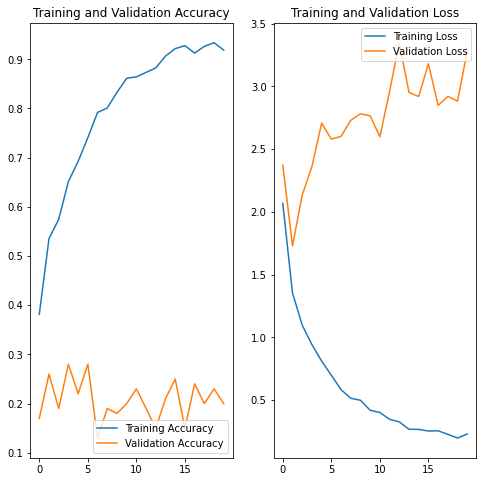

In [31]:
visualize_accuracy(history, num_epochs)

#### MODEL 5: CONV 3D + IMAGE SIZE 160X160

In [44]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 160, 160  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 160, 160)
                    new_size = (160, 160)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Normalize and add to batch
                    batch_data[folder, idx] = image / 255.0
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    batch_data[folder, idx] = image / 255.0

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [45]:
batch_size=64
num_epochs=10

In [46]:
classes = 5
input_shape = (30, 160, 160, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))  # Pooling to reduce dimensionality

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.5))  # Further increased Dropout

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

In [47]:
#Adding the SGD optimizer
from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization_19 (Bat  (None, 30, 160, 160, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 30, 80, 80, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 30, 80, 80, 16)    3472      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 80, 80, 16)   64        
 chNormalization)                                                
                                                      

In [48]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [49]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 2.1089 - categorical_accuracy: 0.3544Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 4.65929, saving model to model_init_2024-10-2706_00_01.322243/model-00001-2.10891-0.35445-4.65929-0.27000.h5
11/11 [==============================] - 88s 8s/step - loss: 2.1089 - categorical_accuracy: 0.3544 - val_loss: 4.6593 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.3183 - categorical_accuracy: 0.5234
Epoch 00002: val_loss improved from 4.65929 to 4.65632, saving model to model_init_2024-10-2706_00_01.322243/model-00002-1.31828-0.52338-4.65632-0.21000.h5
11/11 [==============================] - 77s 8s/step - loss: 1.3183 - categorical_accuracy: 0.5234 - val_loss: 4.6563 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/10
11/11

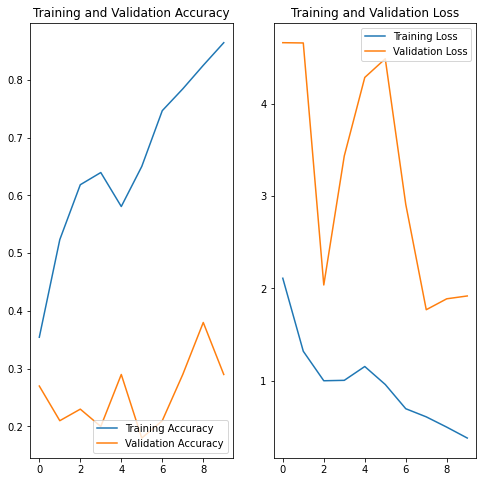

In [52]:
visualize_accuracy(history, num_epochs)

#### MODEL 6: CONV3D 32 BATCH SIZE + L2 REGULARIZATION

In [53]:
batch_size=32
num_epochs=10

In [54]:
from tensorflow.keras import regularizers

classes = 5
input_shape = (30, 160, 160, 3)  # Match the input shape from the generator

# Initialize the sequential model
model = Sequential()

# First Convolution Layer with input shape
model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((1, 2, 2)))

# Second Convolution Layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((1, 2, 2)))

# Third Convolution Layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((1, 2, 2)))

# Fourth Convolution Layer
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.5))

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))


In [55]:
#Adding the SGD optimizer
from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization_24 (Bat  (None, 30, 160, 160, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 30, 80, 80, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 30, 80, 80, 16)    3472      
                                                                 
 batch_normalization_25 (Bat  (None, 30, 80, 80, 16)   64        
 chNormalization)                                                
                                                      

In [56]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [57]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [59]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 2.4390 - categorical_accuracy: 0.3560Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 4.00226, saving model to model_init_2024-10-2706_24_46.892660/model-00001-2.43900-0.35596-4.00226-0.23000.h5
21/21 [==============================] - 77s 4s/step - loss: 2.4390 - categorical_accuracy: 0.3560 - val_loss: 4.0023 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.7878 - categorical_accuracy: 0.5023
Epoch 00002: val_loss improved from 4.00226 to 3.31339, saving model to model_init_2024-10-2706_24_46.892660/model-00002-1.78781-0.50226-3.31339-0.30000.h5
21/21 [==============================] - 73s 4s/step - loss: 1.7878 - categorical_accuracy: 0.5023 - val_loss: 3.3134 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/10
21/21

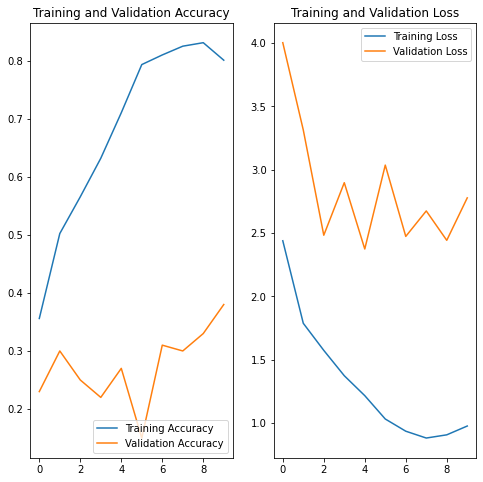

In [60]:
visualize_accuracy(history, num_epochs)

#### MODEL 7: TIME DISTRIBUTED + GRU+ 64 BATCH_SIZE

In [62]:
batch_size = 64
num_epochs=15

In [63]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 160, 160  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 160, 160)
                    new_size = (160, 160)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 1] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 2] / 255.0) #normalise and feed in the image
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 1] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 2] / 255.0) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [65]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Dropout, Dense, Flatten, GRU

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 160  # Height of each frame
img_width = 160   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)

# Initialize the sequential model
model = models.Sequential()

# First TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Second TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Third TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Fourth TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.2)))  # Regularization with Dropout

# Flatten the output from the TimeDistributed layers
model.add(TimeDistributed(Flatten()))

# Add a GRU layer to process the sequence of feature maps
model.add(GRU(128, return_sequences=False))  # Change to return_sequences=True if stacking additional RNN layers

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Additional Dropout layer for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))


In [66]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 158, 158, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 158, 158, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 79, 79, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 77, 77, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 77, 77, 32)  

In [67]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [68]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [69]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/15


2024-10-27 06:49:54.697925: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.86GiB (rounded to 3067576320)requested by op sequential_7/time_distributed_14/batch_normalization_34/FusedBatchNormV3-0-1-TransposeNCHWToNHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-10-27 06:49:54.698040: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2024-10-27 06:49:54.698061: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 205, Chunks in use: 205. 51.2KiB allocated for chunks. 51.2KiB in use in bin. 13.1KiB client-requested in use in bin.
2024-10-27 06:49:54.698072: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 39, Chunks in use: 39. 20.8KiB allocat

ResourceExhaustedError:  OOM when allocating tensor with shape[1920,158,158,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/time_distributed_14/batch_normalization_34/FusedBatchNormV3-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18173]

#### MODEL 8: TIME DISTRIBUTED +GRU +32 BATCH SIZE

In [71]:
batch_size = 32
num_epochs=15

In [72]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 1] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 2] / 255.0) #normalise and feed in the image
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 1] / 255.0) #normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = (image[:, :, 2] / 255.0) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [73]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Dropout, Dense, Flatten, GRU

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)

# Initialize the sequential model
model = models.Sequential()

# First TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Second TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Third TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Fourth TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.2)))  # Regularization with Dropout

# Flatten the output from the TimeDistributed layers
model.add(TimeDistributed(Flatten()))

# Add a GRU layer to process the sequence of feature maps
model.add(GRU(128, return_sequences=False))  # Change to return_sequences=True if stacking additional RNN layers

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Additional Dropout layer for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))


In [74]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 30, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 118, 118, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 57, 57, 32)  

In [75]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [76]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [78]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.0817 - categorical_accuracy: 0.3560Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.70243, saving model to model_init_2024-10-2706_58_03.343008/model-00001-2.08174-0.35596-1.70243-0.32000.h5
21/21 [==============================] - 86s 4s/step - loss: 2.0817 - categorical_accuracy: 0.3560 - val_loss: 1.7024 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5161 - categorical_accuracy: 0.4706
Epoch 00002: val_loss did not improve from 1.70243
21/21 [==============================] - 70s 3s/step - loss: 1.5161 - categorical_accuracy: 0.4706 - val_loss: 1.9893 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.4054 - categorical_accuracy: 0.5038
Epoch 00003: va

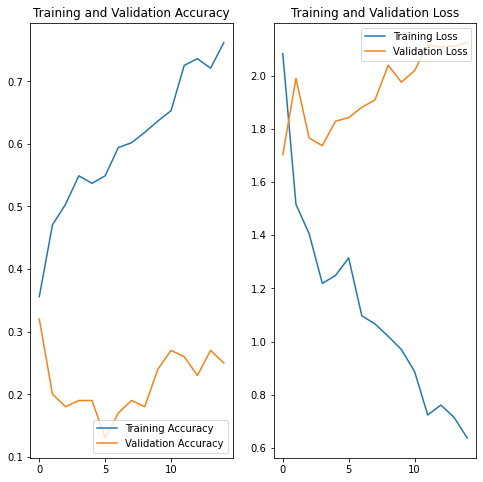

In [80]:
visualize_accuracy(history, num_epochs)

#### MODEL 9: TIME DISTRIBUTED + GRU + 32 BATCH SIZE + DATA AUGMENTATION

In [82]:
batch_size = 32
num_epochs=15

In [83]:
from imgaug import augmenters as iaa

# Define augmentations
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # 50% chance of horizontal flip
    iaa.Affine(
        rotate=(-20, 20),  # rotate images between -20 and +20 degrees
        scale=(0.8, 1.2)   # scale images to between 80% and 120% of their size
    ),
    iaa.Crop(percent=(0, 0.1)),  # crop by 0% to 10% of image height/width
])

def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load and normalize image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32) / 255.0
                    
                    # Apply augmentations
                    image = seq.augment_image(image)
                    
                    # Resize to fixed size
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load and normalize image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32) / 255.0
                    
                    # Apply augmentations
                    image = seq.augment_image(image)
                    
                    # Resize to fixed size
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels



In [84]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Dropout, Dense, Flatten, GRU

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)

# Initialize the sequential model
model = models.Sequential()

# First TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Second TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Third TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Fourth TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.2)))  # Regularization with Dropout

# Flatten the output from the TimeDistributed layers
model.add(TimeDistributed(Flatten()))

# Add a GRU layer to process the sequence of feature maps
model.add(GRU(128, return_sequences=False))  # Change to return_sequences=True if stacking additional RNN layers

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Additional Dropout layer for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))

In [85]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 30, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 118, 118, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 30, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 57, 57, 32)  

In [86]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [87]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [88]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [89]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.2960 - categorical_accuracy: 0.2730Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 2.42056, saving model to model_init_2024-10-2707_22_30.825784/model-00001-2.29597-0.27300-2.42056-0.14000.h5
21/21 [==============================] - 141s 7s/step - loss: 2.2960 - categorical_accuracy: 0.2730 - val_loss: 2.4206 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 2.0883 - categorical_accuracy: 0.2821
Epoch 00002: val_loss improved from 2.42056 to 2.21363, saving model to model_init_2024-10-2707_22_30.825784/model-00002-2.08826-0.28205-2.21363-0.13000.h5
21/21 [==============================] - 137s 7s/step - loss: 2.0883 - categorical_accuracy: 0.2821 - val_loss: 2.2136 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/15
21/

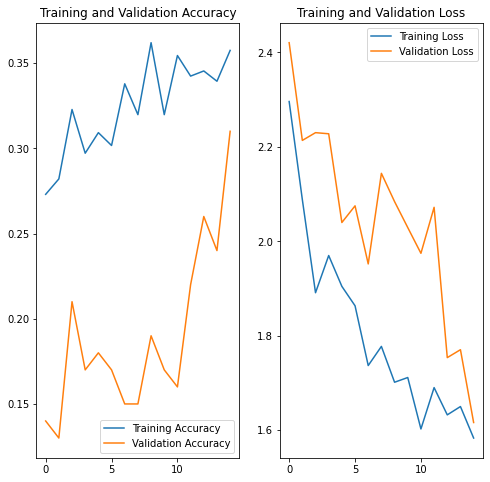

In [90]:
visualize_accuracy(history, num_epochs)

#### MODEL 10: TIME DISTRIBUTED + GRU + 32 BATCH SIZE + DATA AUGMENTATION+ ADDITIONAL GRU LAYERS

In [100]:
batch_size = 32
num_epochs=20

In [41]:
from imgaug import augmenters as iaa

# Define augmentations
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # 50% chance of horizontal flip
    iaa.Affine(
        rotate=(-20, 20),  # rotate images between -20 and +20 degrees
        scale=(0.8, 1.2)   # scale images to between 80% and 120% of their size
    ),
    iaa.Crop(percent=(0, 0.1)),  # crop by 0% to 10% of image height/width
])

def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load and normalize image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32) / 255.0
                    
                    # Apply augmentations
                    image = seq.augment_image(image)
                    
                    # Resize to fixed size
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load and normalize image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32) / 255.0
                    
                    # Apply augmentations
                    image = seq.augment_image(image)
                    
                    # Resize to fixed size
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels



In [102]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, BatchNormalization, Dropout, Flatten

# Initialize the sequential model
model = models.Sequential()

# First TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Second TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Third TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

# Fourth TimeDistributed Convolution Layer
model.add(TimeDistributed(layers.Conv2D(256, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.3)))  # Regularization with Dropout

# Fifth TimeDistributed Convolution Layer (Added for complexity)
model.add(TimeDistributed(layers.Conv2D(256, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.3)))  # Additional Dropout layer

# Flatten the output from the TimeDistributed layers
model.add(TimeDistributed(Flatten()))

# Add a GRU layer to process the sequence of feature maps
model.add(GRU(256, return_sequences=False))  # Increased GRU units for more capacity

# Fully connected layer
model.add(Dense(256, activation='relu'))  # Increased units for better learning
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Additional Dropout layer for regularization

# Output layer with softmax activation for multi-class classification
model.add(Dense(classes, activation='softmax'))


In [103]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.001)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_86 (TimeDi  (None, 30, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_87 (TimeDi  (None, 30, 118, 118, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 30, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_89 (TimeDi  (None, 30, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_90 (TimeDi  (None, 30, 57, 57, 64) 

In [104]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [105]:
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [106]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [107]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.2916 - categorical_accuracy: 0.2624Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 2.09374, saving model to model_init_2024-10-2708_05_11.119536/model-00001-2.29157-0.26244-2.09374-0.15000.h5
21/21 [==============================] - 144s 7s/step - loss: 2.2916 - categorical_accuracy: 0.2624 - val_loss: 2.0937 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.9894 - categorical_accuracy: 0.3122
Epoch 00002: val_loss improved from 2.09374 to 2.08098, saving model to model_init_2024-10-2708_05_11.119536/model-00002-1.98939-0.31222-2.08098-0.17000.h5
21/21 [==============================] - 139s 7s/step - loss: 1.9894 - categorical_accuracy: 0.3122 - val_loss: 2.0810 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
21/

#### Model 11 - CNN- LSTM Model

In [42]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, BatchNormalization, Dropout, Flatten
from keras.layers.recurrent import LSTM

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)
model = models.Sequential()

model.add(TimeDistributed(layers.Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))             
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))


In [43]:
batch_size = 32
num_epochs= 20

In [44]:
from tensorflow.keras import optimizers

# Set up the Adam optimizer with the specified learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [45]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6018 - categorical_accuracy: 0.2594Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.61950, saving model to model_init_2024-10-2709_49_27.273865/model-00001-1.60182-0.25943-1.61950-0.18000.h5
21/21 [==============================] - 159s 8s/step - loss: 1.6018 - categorical_accuracy: 0.2594 - val_loss: 1.6195 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5126 - categorical_accuracy: 0.3303
Epoch 00002: val_loss did not improve from 1.61950
21/21 [==============================] - 145s 7s/step - loss: 1.5126 - categorical_accuracy: 0.3303 - val_loss: 1.6300 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5031 - categorical_accuracy: 0.3107
Epoch

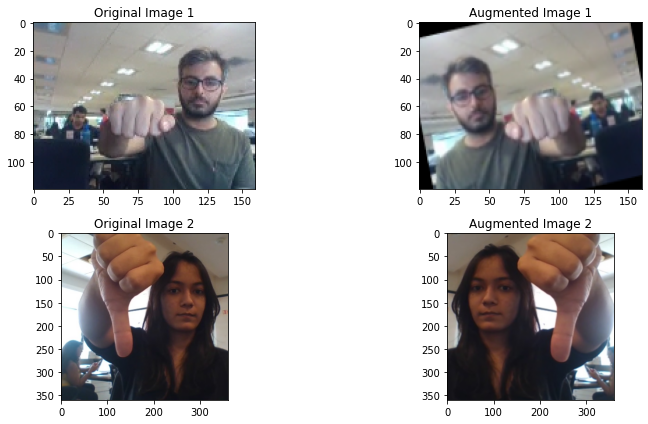

In [51]:
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import numpy as np
from skimage.io import imread
import os
import random

# Define augmentations
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # 50% chance of horizontal flip
    iaa.Affine(
        rotate=(-20, 20),  # rotate images between -20 and +20 degrees
        scale=(0.8, 1.2)   # scale images to between 80% and 120% of their size
    ),
    iaa.Crop(percent=(0, 0.1)),  # crop by 0% to 10% of image height/width
])

def display_random_augmentations(source_path):
    # Randomly select two folders
    folders = os.listdir(source_path)
    chosen_folders = random.sample(folders, 2)
    
    plt.figure(figsize=(12, 6))

    for i, folder in enumerate(chosen_folders):
        img_files = os.listdir(os.path.join(source_path, folder))
        
        # Randomly select an image from each folder
        chosen_image_file = random.choice(img_files)
        original_image = imread(os.path.join(source_path, folder, chosen_image_file)).astype(np.float32) / 255.0
        
        # Apply augmentation
        augmented_image = seq.augment_image(original_image)
        
        # Display original and augmented images
        plt.subplot(2, 2, 2*i + 1)
        plt.imshow(original_image)
        plt.title(f"Original Image {i+1}")
        
        plt.subplot(2, 2, 2*i + 2)
        plt.imshow(augmented_image)
        plt.title(f"Augmented Image {i+1}")
    
    plt.tight_layout()
    plt.show()

# Example usage
display_random_augmentations("/home/datasets/Project_data/train")



we can see that the horizontal flip may cause some misunderstanding issues, so removing it and running the same model

In [52]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Normalize and add to batch
                    batch_data[folder, idx] = image / 255.0
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    batch_data[folder, idx] = image / 255.0

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

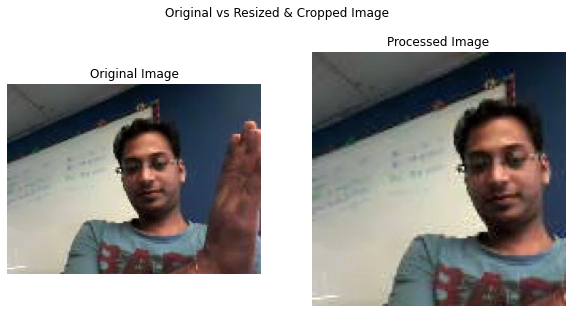

In [76]:
import os
import random
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from PIL import Image

# Function to resize and crop images
def resize_and_crop_image(input_image, crop_box, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    cropped_image = pil_image.crop(crop_box)
    resized_image = cropped_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)

def display_images(original, processed, title="Original vs Processed"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title("Processed Image")
    axes[1].axis('off')
    
    plt.show()

def display_random_resize_and_crop(source_path):
    # Randomly select a folder from the source path
    folders = [f for f in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, f))]
    random_folder = random.choice(folders)
    folder_path = os.path.join(source_path, random_folder)
    
    # Randomly select 1 image from the chosen folder
    img_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    img_file = random.choice(img_files)
    
    # Load the original image
    img_path = os.path.join(folder_path, img_file)
    original_image = imread(img_path).astype(np.float32) / 255.0
    
    # Apply resize and crop
    crop_box = (0, 0, 120, 120)  # Example crop box, adjust as needed
    new_size = (120, 120)         # Example new size, adjust as needed
    processed_image = resize_and_crop_image(original_image * 255.0, crop_box, new_size) / 255.0
    
    # Display the original and processed images
    display_images(original_image, processed_image, title="Original vs Resized & Cropped Image")

# Example usage
display_random_resize_and_crop("/home/datasets/Project_data/train")



Diagnosed the issue with the low accuracy-> it was because of cropping and resizing the image that leads to missing hand gesture in the processed image

without cropping and just resizing

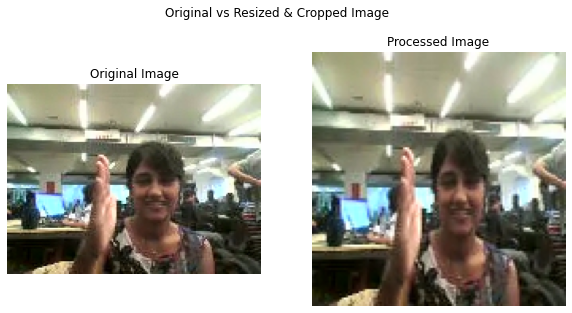

In [78]:
import os
import random
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from PIL import Image

# Function to resize and crop images
def resize_and_crop_image(input_image, crop_box, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    #cropped_image = pil_image.crop(crop_box)
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)

def display_images(original, processed, title="Original vs Processed"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title("Processed Image")
    axes[1].axis('off')
    
    plt.show()

def display_random_resize_and_crop(source_path):
    # Randomly select a folder from the source path
    folders = [f for f in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, f))]
    random_folder = random.choice(folders)
    folder_path = os.path.join(source_path, random_folder)
    
    # Randomly select 1 image from the chosen folder
    img_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    img_file = random.choice(img_files)
    
    # Load the original image
    img_path = os.path.join(folder_path, img_file)
    original_image = imread(img_path).astype(np.float32) / 255.0
    
    # Apply resize and crop
    crop_box = (0, 0, 120, 120)  # Example crop box, adjust as needed
    new_size = (120, 120)         # Example new size, adjust as needed
    processed_image = resize_and_crop_image(original_image * 255.0, crop_box, new_size) / 255.0
    
    # Display the original and processed images
    display_images(original_image, processed_image, title="Original vs Resized & Cropped Image")

# Example usage
display_random_resize_and_crop("/home/datasets/Project_data/train")

#### MODEL 12: APPLYING ONLY RESIZE IMAGE AND FOLLOWING THE SAME STEPS AS ABOVE

In [104]:
# Generator function

#Fucntion to resize the images

from PIL import Image
import numpy as np
from skimage.io import imread  # Assuming you're using skimage to read images
import os

# Function to resize and crop images
def resize_and_crop_image(input_image, crop_box, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    #cropped_image = pil_image.crop(crop_box)
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)


def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # Crop and resize
                    crop_box = (0, 0, 120, 120)
                    new_size = (120, 120)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    
                    # Normalize and add to batch
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_and_crop_image(image, crop_box, new_size)
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
            
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [105]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, BatchNormalization, Dropout, Flatten
from keras.layers.recurrent import LSTM

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)
model = models.Sequential()

model.add(TimeDistributed(layers.Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(time_steps, img_height, img_width, channels)))             
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax'))

In [106]:
batch_size = 32
num_epochs= 30

In [107]:
from tensorflow.keras import optimizers

# Set up the Adam optimizer with the specified learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [108]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [109]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [110]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [111]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5252 - categorical_accuracy: 0.3167Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.88655, saving model to model_init_2024-10-2712_16_43.728563/model-00001-1.52523-0.31674-1.88655-0.26000.h5
21/21 [==============================] - 92s 4s/step - loss: 1.5252 - categorical_accuracy: 0.3167 - val_loss: 1.8866 - val_categorical_accuracy: 0.2600 - lr: 2.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.2818 - categorical_accuracy: 0.4615
Epoch 00002: val_loss improved from 1.88655 to 1.79816, saving model to model_init_2024-10-2712_16_43.728563/model-00002-1.28181-0.46154-1.79816-0.28000.h5
21/21 [==============================] - 90s 4s/step - loss: 1.2818 - categorical_accuracy: 0.4615 - val_loss: 1.7982 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/

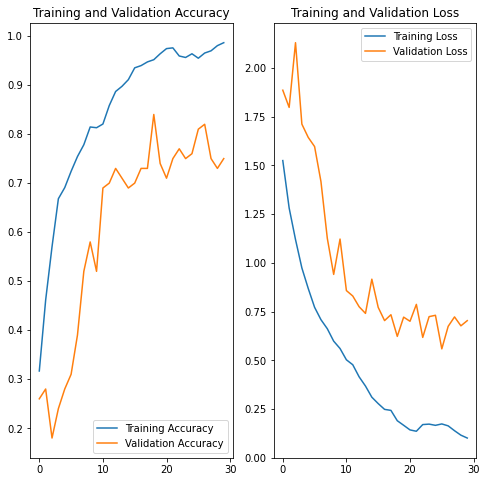

In [112]:
visualize_accuracy(history, num_epochs)

#### OBSERVATIONS: Better results compared to all the models, but there seems to be overfitting, lets add L2 regularization and run for 20 epochs

#### MODEL 13. Model 12+ L2 regularization

In [115]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, BatchNormalization, Dropout, Flatten, LSTM

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)
l2_reg = 0.01     # L2 regularization factor

model = models.Sequential()

# Adding Conv2D layers with L2 regularization
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg)), 
                          input_shape=(time_steps, img_height, img_width, channels)))             
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(256, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Flatten()))

# Adding LSTM with L2 regularization
model.add(LSTM(64, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))

# Adding Dense layers with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg)))


In [116]:
from tensorflow.keras import optimizers

# Set up the Adam optimizer with the specified learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [117]:
num_epochs=20

In [118]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [119]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [120]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 9.9275 - categorical_accuracy: 0.2881Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 9.90330, saving model to model_init_2024-10-2713_07_08.818214/model-00001-9.92748-0.28808-9.90330-0.24000.h5
21/21 [==============================] - 214s 10s/step - loss: 9.9275 - categorical_accuracy: 0.2881 - val_loss: 9.9033 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 9.3291 - categorical_accuracy: 0.4751
Epoch 00002: val_loss improved from 9.90330 to 9.60611, saving model to model_init_2024-10-2713_07_08.818214/model-00002-9.32915-0.47511-9.60611-0.21000.h5
21/21 [==============================] - 160s 8s/step - loss: 9.3291 - categorical_accuracy: 0.4751 - val_loss: 9.6061 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch

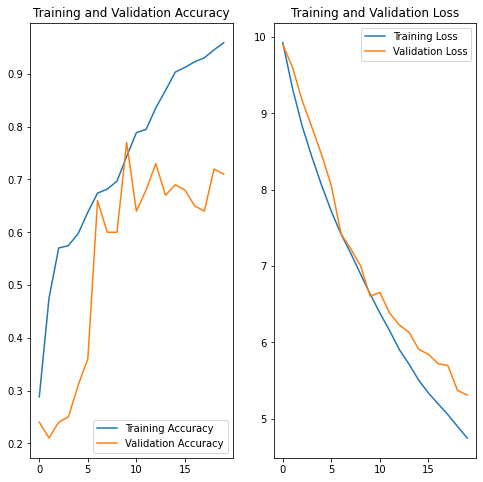

In [121]:
visualize_accuracy(history, num_epochs)

#### MODEL 13: MODIFYING model 12 by removing a neural layer with 256 neurons

In [123]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import TimeDistributed, Dense, BatchNormalization, Dropout, Flatten, LSTM

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)
l2_reg = 0.01     # L2 regularization factor

model = models.Sequential()

# Adding Conv2D layers with L2 regularization
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg)), 
                          input_shape=(time_steps, img_height, img_width, channels)))             
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

model.add(TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

model.add(TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

model.add(TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

# Adding LSTM with L2 regularization
model.add(LSTM(64, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))

# Adding Dense layers with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(classes, activation='softmax'))  # Optional: you can add L2 regularization here as well if desired


In [124]:
from tensorflow.keras import optimizers

# Set up the Adam optimizer with the specified learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)

# Compile the model with the optimizer and loss function
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [125]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime
# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

In [126]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [127]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 8.4051 - categorical_accuracy: 0.3243Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 8.82558, saving model to model_init_2024-10-2714_11_57.049592/model-00001-8.40510-0.32428-8.82558-0.22000.h5
21/21 [==============================] - 92s 4s/step - loss: 8.4051 - categorical_accuracy: 0.3243 - val_loss: 8.8256 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 7.7269 - categorical_accuracy: 0.4947
Epoch 00002: val_loss improved from 8.82558 to 8.25698, saving model to model_init_2024-10-2714_11_57.049592/model-00002-7.72691-0.49472-8.25698-0.27000.h5
21/21 [==============================] - 87s 4s/step - loss: 7.7269 - categorical_accuracy: 0.4947 - val_loss: 8.2570 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 3/

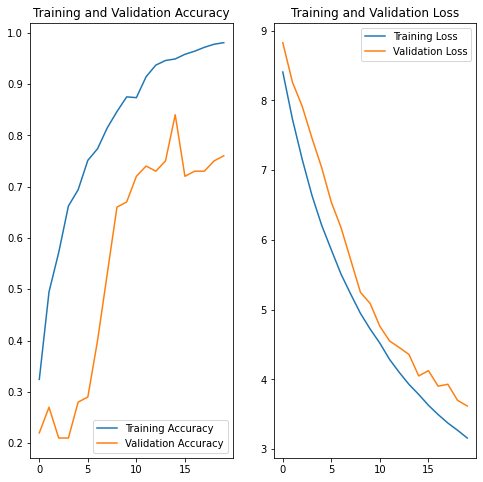

In [128]:
visualize_accuracy(history, num_epochs)

The best model till now is 